<a href="https://colab.research.google.com/github/suminarwb/hate-speech-id/blob/main/LSTM_testing5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
filename1 = "/content/drive/My Drive/Tesis/best_model_lstm_ft1_testing5.h5"
filename2 = "/content/drive/My Drive/Tesis/best_model_lstm_ft2_testing5.h5"

In [3]:
import os
import pandas as pd
from tqdm.auto import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from gensim.models import FastText
import numpy as np # linear algebra

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import everything that will be used
import string
import random
import logging
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Mounted at /content/drive


In [4]:
data = pd.read_excel("/content/drive/My Drive/Tesis/dataset_basic.xlsx", sheet_name='Sheet1' )

df = pd.DataFrame(data, columns=['Tweet', 'HS', 'Subject', 'Category'])
df.Tweet.astype(str)
df.Subject.astype(str)
df.Category.astype(str)
df.head()

,Tweet,HS,Subject,Category
0,disaat semua cowok berusaha melacak perhatian ...,1,Individual,Other
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,None,None
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,None,None
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,None,None
4,USER USER Kaum cebong kapir udah keliatan dong...,1,Group,Religion


In [5]:
df.shape

(13169, 4)

In [6]:
df.dropna(subset=['Tweet'])

,Tweet,HS,Subject,Category
0,disaat semua cowok berusaha melacak perhatian ...,1,Individual,Other
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,None,None
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,None,None
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,None,None
4,USER USER Kaum cebong kapir udah keliatan dong...,1,Group,Religion
...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,Individual,Physical
13165,USER Kasur mana enak kunyuk',0,None,None
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,None,None
13167,USER USER USER USER Bom yang real mudah terdet...,0,None,None


In [7]:
df.shape

(13169, 4)

In [8]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class TweetsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for review in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            #print(review)
            review =  review.lower()
            
            #[:-1] means 0 to n-1 column. cause last element after the last full stop is null. 
            for sentence in review.split('.')[:-1]:
                # Clean string of all punctuation
                #sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words
                
sentences = TweetsIterator(df)

In [9]:
#w2v_model = FastText(sentences, size=100, window=5, min_count=10, workers=8)

#w2v_model.save('/content/drive/My Drive/Tesis/fasttext_trained_model')

In [10]:
fasttext_model = FastText.load('/content/drive/My Drive/Tesis/model_2.fasttext')
w2v_model = fasttext_model

In [11]:
ft_weights = fasttext_model.wv.vectors

In [12]:
vocab_size, embedding_size = ft_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 5098 - Embedding Dim: 100


In [13]:
import pickle

In [14]:
#with open("/content/drive/My Drive/Tesis/fasttext_final_vector.pickle", "wb") as fp:   #Pickling
#   pickle.dump(ft_weights, fp)

In [15]:
#with open("/content/drive/My Drive/Tesis/fasttext_final_vector.pickle", "rb") as fp:   # Unpickling
#    ft_weights = pickle.load(fp)

In [16]:
fasttext_model_wv = fasttext_model.wv

In [17]:
fasttext_model_wv.most_similar('dungu')

[('tolol', 0.41145822405815125),
 ('kedunguan', 0.3520643413066864),
 ('buta', 0.327386736869812),
 ('goblok', 0.32248055934906006),
 ('bui', 0.3146737217903137),
 ('ttp', 0.31324124336242676),
 ('propaganda', 0.30799058079719543),
 ('bego', 0.30664730072021484),
 ('jual', 0.30517804622650146),
 ('dongo', 0.3021629750728607)]

In [18]:
#function
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

In [19]:
fasttext_model_wv['dungu']

array([-7.3799098e-01,  1.2306455e+00, -9.3167686e-01,  2.0579753e+00,
        7.8129286e-01, -1.7755218e+00, -1.5602828e+00,  2.4126935e+00,
        2.5625296e+00, -1.2359418e+00, -1.6853956e+00, -2.9912445e-01,
       -4.0481403e-01,  3.3111153e+00,  2.8109457e+00, -3.6457362e+00,
       -8.1324738e-01,  2.2167473e+00, -2.7627599e+00, -3.3809688e+00,
        1.3167839e+00, -2.9897714e+00, -4.7595806e+00, -5.7132840e-01,
        1.1805489e+00,  1.4087812e+00,  2.5614233e+00, -1.9704891e+00,
       -4.3191510e-01, -2.6898413e+00, -6.5269685e-01,  1.7109306e+00,
       -2.6458054e+00, -7.6818669e-01, -6.8697941e-01, -1.2269723e-01,
        7.7783620e-01, -2.1097422e+00,  8.7654096e-01,  1.6813298e-01,
       -2.9374783e+00,  4.7971683e+00,  2.4751294e+00, -5.1879196e+00,
        2.9114658e-01, -2.7055914e+00,  2.2727730e+00, -2.4621179e+00,
        1.1902910e+00, -3.1324497e-01,  6.0963064e-01,  2.6044686e+00,
        4.0279350e-01, -7.3886740e-01,  1.3889604e+00,  1.6843572e-01,
      

In [20]:
from sklearn.manifold import TSNE

In [21]:
vocab_size, embedding_layer_input_size = ft_weights.shape
print(vocab_size, embedding_layer_input_size)

5098 100


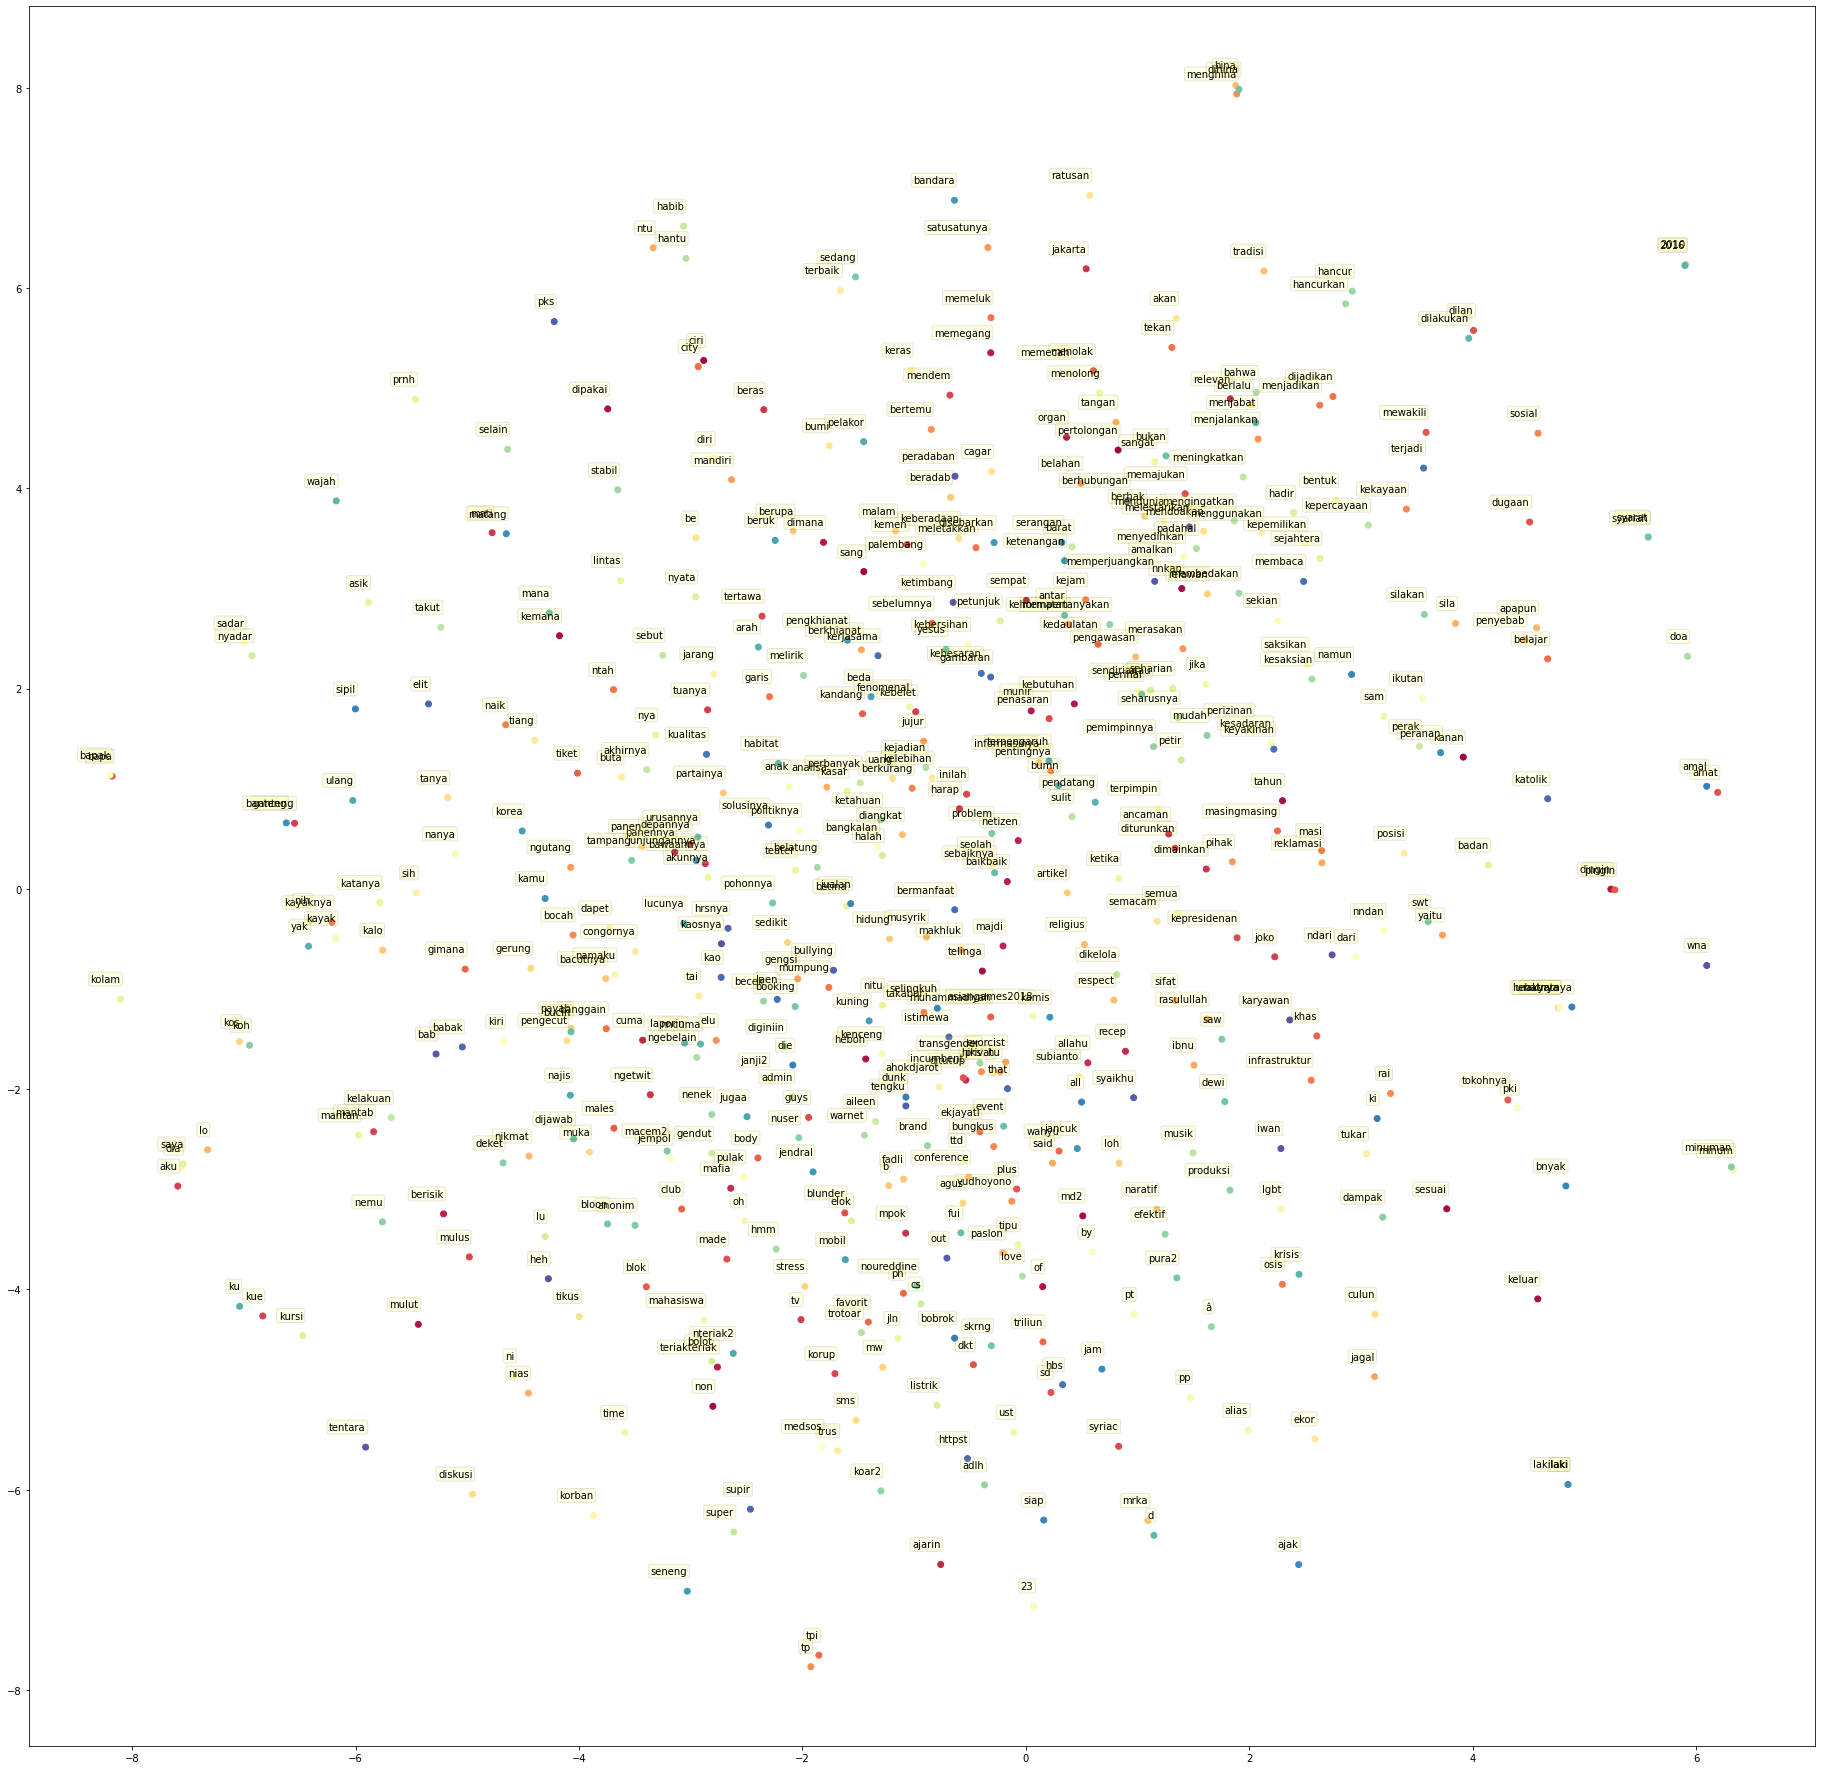

In [22]:
n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate fasttext embeddings of each word
word_vecs = np.array([fasttext_model_wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

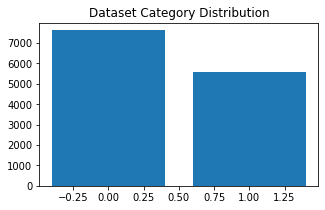

In [23]:
categories, ccount = np.unique(df.HS, return_counts=True)

plt.figure(figsize=(5, 3))
plt.title("Dataset Category Distribution")
plt.bar(categories, ccount, align='center')
plt.show()

In [24]:
df.shape

(13169, 4)

In [25]:
def word2idx(word):
    try:
        #return fasttext_model_wv[word]
        return fasttext_model_wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
    
def idx2word(idx):
    return fasttext_model_wv.index2word[idx]

In [26]:

# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored

class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.HS, self.ccount = np.unique(dataset.HS, return_counts=True)
        
        self.seq_length = seq_length
        
    def __iter__(self):
        for review, score in zip(self.dataset.iloc[:,0], self.dataset.iloc[:,1]):
            # Make all characters lower-case
            review = str(review).lower()
            
            # Clean string of all punctuation
            review = review.translate(self.translator)

            words = np.array([word2idx(w) for w in review.split(' ')[:self.seq_length] if w != ''])
                                
            # basically what is being done here is this - we take the review and score of a row. 
            # then we send the score intact
            # but, we take the review and split it into an array of words. then those words are searched in the fasttext_model_wv
            # and their index in that model's internal map / dictionary is found. those indexes are saved in an array. 
            # this array is padded with 0 so that these can be of MAX_LENGTH
            # replacing not found elements with 0 doesn't harm as it's the most used word, it will be ignored at some point. 
            
            yield (words, score)

sequences = SequenceIterator(df, MAX_SEQUENCE_LENGTH)

In [27]:
# Used for generating the labels in the set
# cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

# we don't need this dictionary actually as our score field itself contains integer values. 
# although if you want you can name them. 

score_dict = {
                0 : 'Netral', 
                1 : 'Hate Speech'
             }


set_x = []
set_y = []

for w, s in sequences:
    set_x.append(w)
    set_y.append(s)
#    
#    
## Padding sequences with 0.
#

set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)

set_y = np.array(set_y)
#set_individu = np.array(set_individu)
#set_group = np.array(set_group)
#set_religion = np.array(set_religion)
#set_race = np.array(set_race)
#set_physical = np.array(set_physical)
#set_gender = np.array(set_gender)


In [28]:
print(set_x.shape)

# set_y just has the score values serially. 

print(set_y.shape)

print(set_y)


(13169, 200)
(13169,)
[1 0 0 ... 0 0 1]


Train Shapes - X: (10535, 200) - Y: (10535,)
Val Shapes - X: (2634, 200) - Y: (2634,)


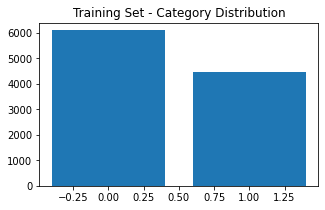

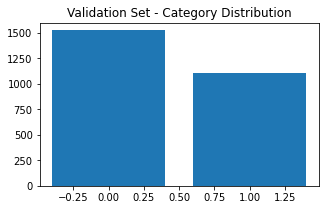

[1524 1110]


In [29]:
VALID_PER = 0.20 # Percentage of the whole set that will be separated for validation

from sklearn.model_selection import train_test_split
total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

#random_i = random.sample(range(total_samples), total_samples)
#train_x = set_x[random_i[:n_train]]
#train_y = set_y[random_i[:n_train]]
#val_x = set_x[random_i[n_train:n_train+n_val]]
#val_y = set_y[random_i[n_train:n_train+n_val]]

train_x, val_x, train_y, val_y = train_test_split(set_x, set_y, test_size=VALID_PER, shuffle=False)

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Training Set - Category Distribution")
# plt.xticks(range(len(score_dict)), score_dict.values())
plt.bar(categories, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Category Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

print(ccount)

n_categories = len(categories)


In [30]:
vocab_size, embedding_layer_output_size = ft_weights.shape
print(vocab_size, embedding_layer_output_size)

print(train_y)

5098 100
[1 0 0 ... 1 0 0]


In [31]:
x = set_x
input =  Input(shape=(set_x.shape[1],))
x = Embedding(input_dim=vocab_size, # 34867
                    output_dim=embedding_layer_output_size, # 100
                    weights=[ft_weights],
                    input_length=MAX_SEQUENCE_LENGTH, # 200
                    mask_zero=True,
                    trainable=False)(input)

word_length = 23
char_length = len("abcdefghijklmnopqrstuvwxyz.,?!*&#-_|'") + 11
hidden_nodes = 20 #int((2/3) * (word_length * char_length))

print('Word Length : ' , word_length)

x = SpatialDropout1D(0.2)(x)
x = LSTM(hidden_nodes, dropout=0.2, recurrent_dropout=0.2)(x)
out1 = Dense(n_categories, activation='softmax', name='hs')(x)
model = Model(inputs = input, outputs=[out1])


loss_name = 'categorical_crossentropy'

train_y = pd.get_dummies(train_y).values

val_y = pd.get_dummies(val_y).values

print(val_y)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(filename1, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

#optimizer = rmsprop_v2(learning_rate=0.01)

model.compile(optimizer="adam", loss=loss_name, metrics=['accuracy'])
model.optimizer.lr.assign(0.00005)

import keras.backend as K

print(K.eval(model.optimizer.lr))

#history = model.fit(x=train_x, y={"hs" : train_y}, epochs=30, batch_size=32, validation_data=(val_x, {"hs" : val_y}), verbose=1, shuffle=False, callbacks=[es, mc])
history = model.fit(x=train_x, y={"hs" : train_y}, epochs=500, batch_size=32, validation_split=0.1, verbose=1, callbacks=[es, mc])

Word Length :  23
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]
5e-05
Epoch 1/500
297/297 [==============================] - 76s 242ms/step - loss: 0.7201 - accuracy: 0.5223 - val_loss: 0.7031 - val_accuracy: 0.5550

Epoch 00001: val_accuracy improved from -inf to 0.55503, saving model to /content/drive/My Drive/Tesis/best_model_lstm_ft1_testing5.h5
Epoch 2/500
297/297 [==============================] - 72s 244ms/step - loss: 0.7082 - accuracy: 0.5381 - val_loss: 0.6898 - val_accuracy: 0.5731

Epoch 00002: val_accuracy improved from 0.55503 to 0.57306, saving model to /content/drive/My Drive/Tesis/best_model_lstm_ft1_testing5.h5
Epoch 3/500
297/297 [==============================] - 74s 250ms/step - loss: 0.6988 - accuracy: 0.5526 - val_loss: 0.6802 - val_accuracy: 0.5825

Epoch 00003: val_accuracy improved from 0.57306 to 0.58254, saving model to /content/drive/My Drive/Tesis/best_model_lstm_ft1_testing5.h5
Epoch 4/500
297/297 [==============================] - 73s 244ms/step - loss

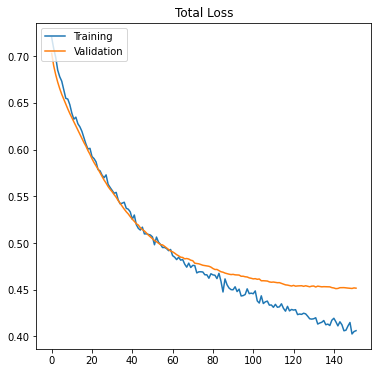

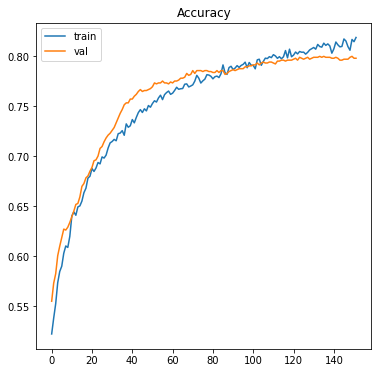

In [32]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix

saved_model = load_model(filename1)

y_pred = saved_model.predict(val_x, verbose=1, batch_size=32)
y_pred_bool = np.argmax(y_pred, axis=1)
#val_y = pd.get_dummies(val_y).values
val_true = np.argmax(val_y, axis=1)

print(classification_report(val_true, y_pred_bool, digits=4))
print('Precision Score : ', precision_score(val_true, y_pred_bool , average="macro"))
print('Recall Score : ', recall_score(val_true, y_pred_bool , average="macro"))
print('F1 Score : ', f1_score(val_true, y_pred_bool , average="macro"))

(tn, fp, fn, tp) = confusion_matrix(val_true, y_pred_bool).ravel()

print((tn, fp, fn, tp) )

print(y_pred_bool)

83/83 [==============================] - 3s 32ms/step
              precision    recall  f1-score   support

           0     0.8436    0.8353    0.8394      1524
           1     0.7769    0.7874    0.7821      1110

    accuracy                         0.8151      2634
   macro avg     0.8102    0.8113    0.8108      2634
weighted avg     0.8155    0.8151    0.8153      2634

Precision Score :  0.8102469626684339
Recall Score :  0.8113446123288643
F1 Score :  0.8107679064961044
(1273, 251, 236, 874)
[0 0 0 ... 0 0 1]


In [34]:
accr = saved_model.evaluate(val_x, val_y)
print(accr)
print('Test set\n  Loss HS: {:0.3f}\n  Accuracy HS: {:0.3f}'.format(accr[0], accr[1]))


83/83 [==============================] - 3s 32ms/step - loss: 0.4157 - accuracy: 0.8151
[0.4157252013683319, 0.8151100873947144]
Test set
  Loss HS: 0.416
  Accuracy HS: 0.815


In [35]:
#model.save("/content/drive/My Drive/Tesis/model_hs_32")

Model Labeling HS

In [36]:
class SequenceIteratorCategories:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.Subject, self.ccount = np.unique(dataset.HS, return_counts=True)
        
        self.seq_length = seq_length
        
    def __iter__(self):
        for review, subject, category in zip(self.dataset.iloc[:,0], self.dataset.iloc[:,2], self.dataset.iloc[:,3]):
            # Make all characters lower-case
            review = str(review).lower()
            
            # Clean string of all punctuation
            review = review.translate(self.translator)

            words = np.array([word2idx(w) for w in review.split(' ')[:self.seq_length] if w != ''])
                                
            # basically what is being done here is this - we take the review and score of a row. 
            # then we send the score intact
            # but, we take the review and split it into an array of words. then those words are searched in the fasttext_model_wv
            # and their index in that model's internal map / dictionary is found. those indexes are saved in an array. 
            # this array is padded with 0 so that these can be of MAX_LENGTH
            # replacing not found elements with 0 doesn't harm as it's the most used word, it will be ignored at some point. 
            
            yield (words, subject, category)

sequences_ = SequenceIteratorCategories(df.loc[df['HS'] == 1], MAX_SEQUENCE_LENGTH)

In [37]:
set_x2 = []
set_sub = []
set_cat = []

for w, s, c in sequences_:
    set_x2.append(w)
    set_sub.append(s)
    set_cat.append(c)
#    
#    
## Padding sequences with 0.
#
set_x2 = pad_sequences(set_x2, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_sub = np.array(set_sub)
set_cat = np.array(set_cat)

In [38]:
print(set_x2.shape)

# set_y just has the score values serially. 

print(set_cat.shape)

print(set_cat)

(5561, 200)
(5561,)
['Other' 'Religion' 'Other' ... 'Other' 'Physical' 'Other']


Train Shapes - X: (4726, 200) - Y: (4726,)
Val Shapes - X: (835, 200) - Y: (835,)


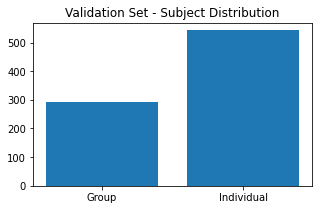

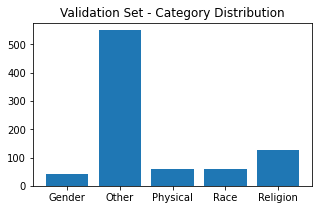

[ 42 549  61  58 125]


In [39]:
VALID_PER = 0.15 # Percentage of the whole set that will be separated for validation

from sklearn.model_selection import train_test_split
total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val


train_x, val_x, train_sub, val_sub, train_cat, val_cat = train_test_split(set_x2, set_sub, set_cat, test_size=VALID_PER, random_state=42)

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_sub.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_sub.shape))

subjects, ccount = np.unique(val_sub, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Subject Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(subjects, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_cat, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Category Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)
n_subjects = len(subjects)
print(ccount)

In [40]:
from keras.models import Model

x = set_x2
input =  Input(shape=(set_x2.shape[1],))
x = Embedding(input_dim=vocab_size, # 34867
                    output_dim=embedding_layer_output_size, # 100
                    weights=[ft_weights],
                    input_length=MAX_SEQUENCE_LENGTH, # 200
                    mask_zero=True,
                    trainable=False)(input)
word_length = 23
char_length = len("abcdefghijklmnopqrstuvwxyz.,?!*&#-_|'") + 11
hidden_nodes = 20 #int((2/3) * (word_length * char_length))

x = SpatialDropout1D(0.2)(x)
x = LSTM(hidden_nodes, dropout=0.2, recurrent_dropout=0.2)(x)
out1 = Dense(n_subjects, activation='softmax', name='subject')(x)
out2 = Dense(n_categories, activation='softmax', name='category')(x)
model2 = Model(inputs = input, outputs=[out1, out2])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint(filename2, monitor='val_subject_accuracy', mode='max', verbose=1, save_best_only=True)


loss_name = 'categorical_crossentropy'

train_sub_i = pd.get_dummies(train_sub).values
train_cat_i = pd.get_dummies(train_cat).values
val_sub_i = pd.get_dummies(val_sub).values
val_cat_i = pd.get_dummies(val_cat).values


model2.compile(optimizer='adam', loss=loss_name, metrics=['accuracy'])
model2.optimizer.lr.assign(0.00005)

#history = model2.fit(x=train_x, y={"subject" : train_sub_i, "category" : train_cat_i}, epochs=50, batch_size=32, validation_data=(val_x, {"subject" : val_sub_i, "category" : val_cat_i}), verbose=1, shuffle=False, callbacks=[es, mc])
history = model2.fit(x=train_x, y={"subject" : train_sub_i, "category" : train_cat_i}, epochs=1000, batch_size=32, validation_split=0.1, verbose=1, callbacks=[es, mc])

Epoch 1/1000
133/133 [==============================] - 34s 232ms/step - loss: 2.4460 - subject_loss: 0.7599 - category_loss: 1.6860 - subject_accuracy: 0.5083 - category_accuracy: 0.2137 - val_loss: 2.3900 - val_subject_loss: 0.7330 - val_category_loss: 1.6569 - val_subject_accuracy: 0.5560 - val_category_accuracy: 0.2368

Epoch 00001: val_subject_accuracy improved from -inf to 0.55603, saving model to /content/drive/My Drive/Tesis/best_model_lstm_ft2_testing5.h5
Epoch 2/1000
133/133 [==============================] - 30s 227ms/step - loss: 2.3747 - subject_loss: 0.7447 - category_loss: 1.6300 - subject_accuracy: 0.5276 - category_accuracy: 0.2506 - val_loss: 2.3203 - val_subject_loss: 0.7201 - val_category_loss: 1.6002 - val_subject_accuracy: 0.5645 - val_category_accuracy: 0.2854

Epoch 00002: val_subject_accuracy improved from 0.55603 to 0.56448, saving model to /content/drive/My Drive/Tesis/best_model_lstm_ft2_testing5.h5
Epoch 3/1000
133/133 [==============================] - 30s

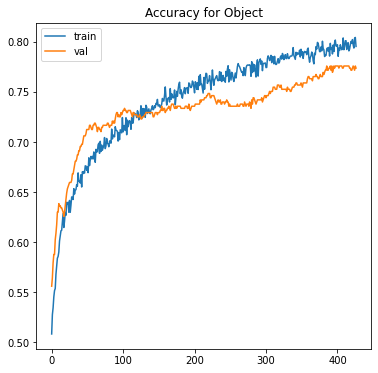

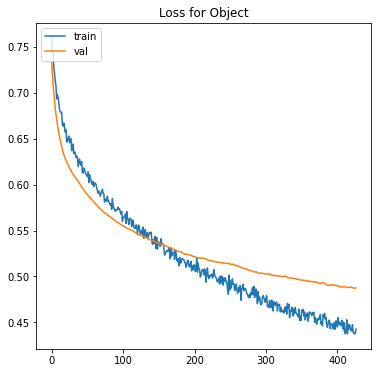

In [41]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['subject_accuracy'])
plt.plot(history.history['val_subject_accuracy'])
plt.title('Accuracy for Object')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(history.history['subject_loss'])
plt.plot(history.history['val_subject_loss'])
plt.title('Loss for Object')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

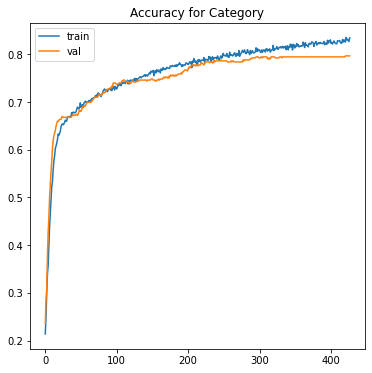

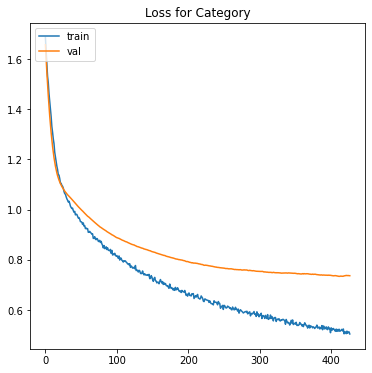

In [42]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['category_accuracy'])
plt.plot(history.history['val_category_accuracy'])
plt.title('Accuracy for Category')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(history.history['category_loss'])
plt.plot(history.history['val_category_loss'])
plt.title('Loss for Category')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score, precision_score, recall_score, confusion_matrix


saved_model2 = load_model(filename2)

(pred_sub, pred_cat) = saved_model2.predict(val_x, verbose=1, batch_size=32)
y_pred_bool = np.argmax(pred_sub, axis=1)
labels = ['Group', 'Individual']

pred_sub_lbl = []

for s in y_pred_bool:
    pred_sub_lbl.append(labels[s])

val_true = val_sub


print(classification_report(val_true, pred_sub_lbl, digits=4))
print('Precision Score : ', precision_score(val_true, pred_sub_lbl , average="macro"))
print('Recall Score : ', recall_score(val_true, pred_sub_lbl , average="macro"))
print('F1 Score : ', f1_score(val_true, pred_sub_lbl, average="macro"))
(tn, fp, fn, tp) = confusion_matrix(val_true,pred_sub_lbl).ravel()
print(tn, fp, fn, tp)
print(confusion_matrix(val_true,pred_sub_lbl))



27/27 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

       Group     0.6932    0.5939    0.6397       293
  Individual     0.7962    0.8579    0.8259       542

    accuracy                         0.7653       835
   macro avg     0.7447    0.7259    0.7328       835
weighted avg     0.7601    0.7653    0.7606       835

Precision Score :  0.7447299841728975
Recall Score :  0.7258951173129479
F1 Score :  0.7328191933967193
174 119 77 465
[[174 119]
 [ 77 465]]


In [44]:
(pred_sub, pred_cat) = saved_model2.predict(val_x, verbose=1, batch_size=32)
pred_number = np.argmax(pred_cat, axis=1)

labels = ['Gender', 'Other', 'Physical', 'Race', 'Religion']

y_pred_bool = []

for s in pred_number:
    y_pred_bool.append(labels[s])

val_true = val_cat


print(classification_report(val_true, y_pred_bool, digits=4))
print('Precision Score : ', precision_score(val_true, y_pred_bool , average="macro"))
print('Recall Score : ', recall_score(val_true, y_pred_bool , average="macro"))
print('F1 Score : ', f1_score(val_true, y_pred_bool , average="macro"))

print(confusion_matrix(val_true, y_pred_bool))

27/27 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

      Gender     0.8571    0.2857    0.4286        42
       Other     0.8103    0.9490    0.8742       549
    Physical     0.8889    0.2623    0.4051        61
        Race     0.6981    0.6379    0.6667        58
    Religion     0.7850    0.6720    0.7241       125

    accuracy                         0.8024       835
   macro avg     0.8079    0.5614    0.6197       835
weighted avg     0.8068    0.8024    0.7806       835

Precision Score :  0.8078912136485894
Recall Score :  0.5613877161341266
F1 Score :  0.6197200782474643
[[ 12  29   1   0   0]
 [  1 521   1   8  18]
 [  0  45  16   0   0]
 [  0  16   0  37   5]
 [  1  32   0   8  84]]


In [45]:
accr = saved_model2.evaluate(x=val_x, y={"subject" : pd.get_dummies(val_sub).values, "category" : pd.get_dummies(val_cat).values})
print(accr)
print('Test set\n  Loss Subject: {:0.3f}\n  Accuracy Subject: {:0.3f}'.format(accr[1], accr[3]))

print('Test set\n  Loss Category: {:0.3f}\n  Accuracy Category: {:0.3f}'.format(accr[2], accr[4]))

27/27 [==============================] - 1s 31ms/step - loss: 1.1337 - subject_loss: 0.4915 - category_loss: 0.6422 - subject_accuracy: 0.7653 - category_accuracy: 0.8024
[1.133713960647583, 0.4914957880973816, 0.6422181129455566, 0.7652694582939148, 0.802395224571228]
Test set
  Loss Subject: 0.491
  Accuracy Subject: 0.765
Test set
  Loss Category: 0.642
  Accuracy Category: 0.802


In [46]:
#model2.save("/content/drive/My Drive/Tesis/model_hs_label")

In [47]:
from keras.preprocessing.text import Tokenizer
saved_model2 = load_model(filename2)
saved_model = load_model(filename1)
tokenizer = Tokenizer()
new_complaint = "bagaimana perasaan walubi kalo umat budha yg di usir dan di bantai???".lower()
seq = new_complaint.split(' ')
padded = []
for w in seq:
    padded.append(word2idx(w))

padded = pad_sequences([np.array(padded)], maxlen=200, padding='pre', value=0)

pred = saved_model.predict(padded)
labelshs = ['Netral', 'Hate Speech']
labels = ['Group', 'Individual']
labels2 = ['Gender', 'Other', 'Physical', 'Race','Religion']
print("Teks : ", new_complaint)

print(labelshs[np.argmax(pred)], '{:0.2f}%'.format(pred[0][np.argmax(pred)] * 100))
if(np.argmax(pred) == 1):
  (pred1, pred2) = saved_model2.predict(x=padded)
  print('Terget HS : ', labels[np.argmax(pred1)], '{:0.2f}%'.format(pred1[0][np.argmax(pred1)] * 100))
  print('Category HS : ', labels2[np.argmax(pred2)], '{:0.2f}%'.format(pred2[0][np.argmax(pred2)] * 100))

Teks :  bagaimana perasaan walubi kalo umat budha yg di usir dan di bantai???
Hate Speech 70.17%
Terget HS :  Group 90.37%
Category HS :  Religion 92.37%


In [48]:
saved_model.summary()
saved_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 100)          509800    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 20)                9680      
_________________________________________________________________
hs (Dense)                   (None, 2)                 42        
Total params: 519,522
Trainable params: 9,722
Non-trainable params: 509,800
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
L